In [119]:
from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder

Wybieramy dataset na którym będziemy pracować

In [120]:
#url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/reduced_dataset_sdn.csv'
url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/dataset_sdn.csv'
s = requests.get(url).content

Pobieramy go

In [121]:
counters = pd.read_csv(io.StringIO(s.decode('utf-8')))
counters.dt = pd.to_datetime(counters.dt, unit='s')
counters.set_index('dt', inplace=True)

Aby uniknąć problemu z wartościami które nie są uzupełnione w datasecie część z nich zamieniana jest na 0

In [122]:
counters.fillna(value=0, inplace=True)

Następnie wartości które są w formie tekstu zamieniane są na wartości liczbowe (tzw. Bucketing).

In [123]:
countersLabel = counters['label']

IpEncoding = 2

#1 - Bucketing
#2 - Target Encoding

if IpEncoding == 1:
    src_label_encoder = LabelEncoder()
    counters['src'] = src_label_encoder.fit_transform(counters['src'])

    dst_label_encoder = LabelEncoder()
    counters['dst'] = dst_label_encoder.fit_transform(counters['dst'])

    label_encoder = LabelEncoder()
    counters['Protocol'] = label_encoder.fit_transform(counters['Protocol'])
elif IpEncoding == 2:
    #Splitting the data
    y = counters['src']
    features = counters.drop('src',axis=1)

    #Specify the target type
    te = TargetEncoder(smooth="auto",target_type='binary')
    X_trans = te.fit_transform(features, y)

    #Creating a Dataframe
    features_encoded = pd.DataFrame(X_trans, columns = features.columns)

    counters = features_encoded

Dobieramy procent danych testowych których chcemy użyć oraz rodzielamy dataset na dane do uczenia oraz do testu

In [124]:
counters_withoutLabel = counters.drop('label',axis=1)

percentage = 0.2

X_train, X_test, y_train, y_test = train_test_split(counters_withoutLabel, countersLabel, train_size=percentage, random_state=42)

Usuwamy date

In [125]:
y_train.drop(y_train.index[y_train.index == 'dt'], inplace=True)

Tworzenie drzew decyzyjnego

In [126]:
glebokosc = 5
drzewo = tree.DecisionTreeClassifier(criterion='entropy', max_depth=glebokosc)
drzewo_data = drzewo.fit(X_train, y_train)

Rysowanie drzewa decyzyjnego

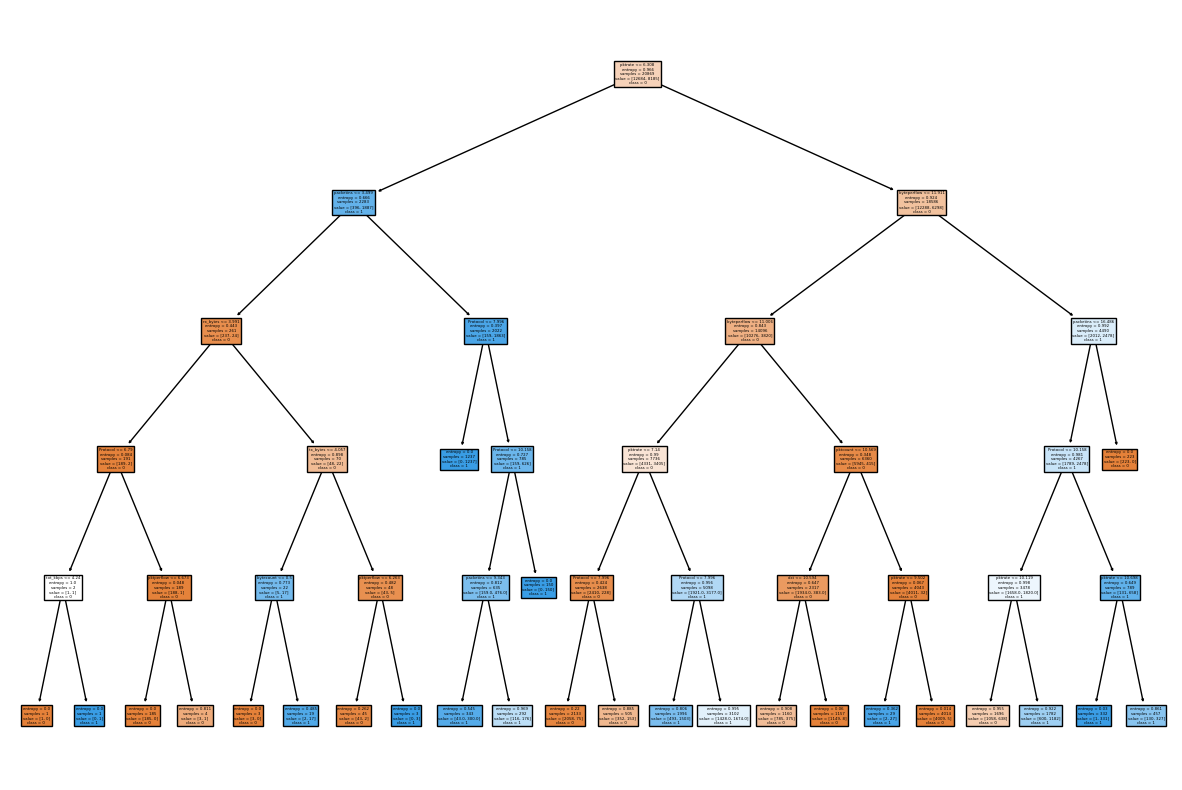

In [127]:
plt.figure(figsize=(15, 10))
tree.plot_tree(
    drzewo_data,
    max_depth=glebokosc,
    class_names=['0', '1'],
    filled=True,
    feature_names=X_train.columns
)
plt.show()

Testowanie dokładności drzewa decyzyjnego

In [128]:
print(f"Dokładność na zbiorze uczącym: {drzewo.score(X_train,y_train)}")
print(f"Dokładność na zbiorze testowym: {drzewo.score(X_test,y_test)}")

Dokładność na zbiorze uczącym: 0.8048780487804879
Dokładność na zbiorze testowym: 0.801032632133787


Ustalanie jak ważne są poszczególne cechy dla modelu

In [129]:
print("Które cechy?")
feature_importances = drzewo.feature_importances_
for i, feature_name in enumerate(X_train.columns):
    print(f"Cecha '{feature_name}' i jej istotność w drzewie: {feature_importances[i]}")

Które cechy?
Cecha 'switch' i jej istotność w drzewie: 0.0
Cecha 'dst' i jej istotność w drzewie: 0.04092764600267646
Cecha 'pktcount' i jej istotność w drzewie: 0.04833857652970175
Cecha 'bytecount' i jej istotność w drzewie: 0.0008461962670043501
Cecha 'dur' i jej istotność w drzewie: 0.0
Cecha 'dur_nsec' i jej istotność w drzewie: 0.0
Cecha 'tot_dur' i jej istotność w drzewie: 0.0
Cecha 'flows' i jej istotność w drzewie: 0.0
Cecha 'packetins' i jej istotność w drzewie: 0.09940309160970444
Cecha 'pktperflow' i jej istotność w drzewie: 0.0018572048529325023
Cecha 'byteperflow' i jej istotność w drzewie: 0.30908821032019296
Cecha 'pktrate' i jej istotność w drzewie: 0.3978739722461026
Cecha 'Pairflow' i jej istotność w drzewie: 0.0
Cecha 'Protocol' i jej istotność w drzewie: 0.09498908069797352
Cecha 'port_no' i jej istotność w drzewie: 0.0
Cecha 'tx_bytes' i jej istotność w drzewie: 0.002468202026888135
Cecha 'rx_bytes' i jej istotność w drzewie: 0.003990490304531307
Cecha 'tx_kbps' i

Zależność głębokości drzewa decyzyjnego od dokładności modelu

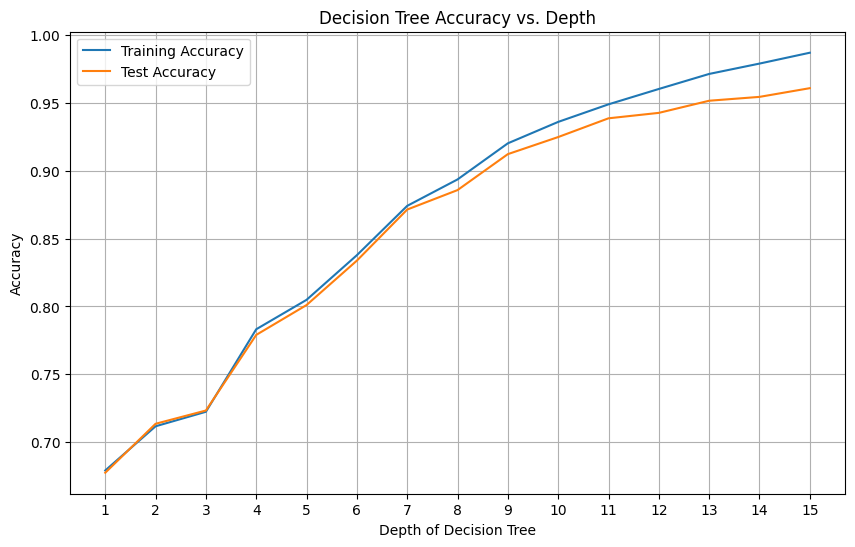

In [130]:
min_depth = 1
max_depth = 15

train_accuracy = []
test_accuracy = []

for i in range(min_depth, max_depth + 1):
    depth = i
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    clf.fit(X_train, y_train)
    
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(min_depth, max_depth + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(min_depth, max_depth + 1), test_accuracy, label='Test Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min_depth, max_depth + 1, step=1))
plt.show()